# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import xgboost as xgb
import random
import pickle


from IPython.display          import display, HTML
from datetime                 import datetime, timedelta
from matplotlib               import pyplot as plt
from IPython.display          import Image
from tabulate                 import tabulate
from scipy                    import stats
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                   import BorutaPy
from sklearn.ensemble         import RandomForestRegressor
from matplotlib.gridspec      import GridSpec
from sklearn.metrics          import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model     import LinearRegression, Lasso

## 0.1.0 Helper Functions

In [88]:
def cramer_v( x, y ):
    cm = pd.crosstab( x , y ).values

    n = cm.sum()

    r,k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - (k-1) * (r-1) / (n-1) ) # chi2 corrigido
    kcorr = k - (k-1)**2 / (n-1) # k corrigido
    rcorr = r - (k-1)**2 / (n-1) # r corrigido
    
    v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
    
    return v

def ml_error( model_name, y , y_hat):
    mae = mean_absolute_error( y , y_hat )
    mape = mean_absolute_percentage_error( y , y_hat )
    rmse = np.sqrt( mean_squared_error( y , y_hat ) )
    
    df = pd.DataFrame( {'Model Name ' :  model_name,
                        'MAE' : mae ,
                        'MAPE' : mape,
                        'RMSE' : rmse}, index = [0] )
    return df

display(HTML("<style>.container { width:100% !important; }</style>"))

def cross_validation( x_training, kfold, model_name, model, verbose = False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold + 1 ) ):
        if verbose:

            print( '\n kfold number{}'.format( k ) )

        # start and end date for validation
        validation_start_date = x_training['date'].max() - timedelta( days = k * (6 * 7) ) # ando menos 6 semanadas multiplicado k
        validation_end_date = x_training['date'].max() - timedelta( days = (k-1) * 6 * 7 ) # ando 6 menos 6 semanas mutiplicado k

        # filtering dataset 
        training = x_training.loc[ x_training['date'] < validation_start_date , : ]
        validation = x_training.loc[(x_training['date'] >= validation_start_date ) & (x_training['date'] <= validation_end_date),: ]

        # training and validation dataset
        xtraining = training.drop( ['date','sales'] , axis = 1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date','sales'], axis = 1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining , ytraining )

        # prediction
        y_hat = m.predict( xvalidation )

        # performance
        m_result = ml_error('Linear Regression', np.expm1( yvalidation ) , np.expm1( y_hat ) )

        # store performance of each iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV':np.round( np.mean(mae_list) , 2 ).astype( str )+ ' +/- ' + np.round( np.std(mae_list),2 ).astype( str ),
                          'MAPE CV': np.round( np.mean(mape_list) , 2 ).astype( str )+ ' +/- ' + np.round( np.std(mape_list),2 ).astype( str ),
                          'RMSE CV':np.round( np.mean(rmse_list) , 2 ).astype( str )+ ' +/- ' + np.round( np.std(rmse_list),2 ).astype( str )},index = [0]) 

def mean_percentage_error( y, yhat ):
    return np.mean( (y - yhat) / y) 

## 0.2.0. Loading Data

In [3]:
# arquivo com as vendas das lojas
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False )

# arquivo com as caracteristicas das lojas
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False )

# merge com base na chave comum "Store"
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.0. Explicação das colunas



* store - ID único para cada loja


* day_of_week - dia da semana em números inteiros


* date - data que foi feita a venda


* sales - valor das vendas em determinado dia


* customers - número de clientes em determinado dia


* open - indicador se a loja estava aberta e fechada 0 = closed, 1 = open


* promo - Indica se a loja estava com promoção naquele dia


* state_holiday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


* school_holiday - indicates if the (Store, Date) was affected by the closure of public schools



* store_type - differentiates between 4 different store models: a, b, c, d


* assortment - describes an assortment level: a = basic, b = extra, c = extended


* competition_distance - distance in meters to the nearest competitor store


* competition_open_since_month - gives the approximate month of the time the nearest competitor was opened


* competition_open_since_year - gives the approximate year of the time the nearest competitor was opened


* promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating



* promo2_since_week - describes the week when the store started participating in Promo2


* promo2_since_year - describes the year when the store started participating in Promo2


* promo_interval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store



## 1.1. Rename Columns

In [5]:
# crio uma lista com o nome das colunas antigos
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# coloco as colunas no estilo snake_case
snake_case = lambda x : inflection.underscore( x ) # defino a lambda function

# aplico o map para cada nome cols_old e crio a lista cols_new
cols_new = list( map( snake_case, cols_old ) )

# renomeio as coluanas do dataset
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print( 'Number of rows {}'.format( df1.shape[0] ) )
print( 'Number of columns {}'.format( df1.shape[1] ) )

Number of rows 1017209
Number of columns 18


## 1.3. Data Types

In [7]:
# alterando o tipo da coluna date de int para date 64 
df1['date'] = pd.to_datetime( df1['date'] )

# exibindo os tipos de dados
print( df1.dtypes )

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object


## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
#competition_distance - Considero que na é igual a não competição. Se eu subsituir na por uma distancia muito grande seria o mesmo que dizer que não existe competição ( o valor máximo df1['competition_distance'] é 75860.0 )
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )


#competition_open_since_month - Considero que quando tiver "na" o competidor abriu no mesmo mes da coluna date ( data da venda ) -- para cada linha "na" pego o mes da coluna date e substituo na coluna competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

#competition_open_since_year - mesma lógica do competition_open_since_month mas aplicado ao ano
df1['competition_open_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['competition_open_since_year']                                                 ) else x['competition_open_since_year'], axis = 1)

#promo2_since_week - Vou considerar que onde tiver "na" a loja não participou da promoção. Então vou substituir o na pela semana da data na coluna date ( data da venda)
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'] , axis = 1)

#promo2_since_year - mesma lógica da promo2_since_week só que substituindo pelo ano
df1['promo2_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'] , axis = 1 )

#promo_interval
month_map = { 1 : 'Jan', 2 :  'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'  } # crio um dicionario com os meses de acordo com os valores da coluna promo_interval

df1['month_map'] = df1['date'].dt.month.map( month_map ) # substituo o numero do mes pelo nome

df1['promo_interval'].fillna( 0 , inplace = True ) # substituo os na por 0

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1) # para cada linha verifico se o valor da coluna month_map existe na coluna promo_interval, se existir retorno 1 ( participa da promoção ) se não existir 0 ( não participa )

## 1.6. Change Types

In [10]:
# verifico se durante a etapa de fill na os tipos de dados se mantiveram inalterados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [11]:
# alterando o tipo da coluna competition_open_since_month  de float64 para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )

# alterando o tipo da coluna competition_open_since_year de float64 para int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

# alterando o tipo da coluna promo2_since_week de float 64para int
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )

# alterando o tipo da coluna promo2_since_year de float64 para int
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' ) 

In [12]:
# verifico novamente o tipo de dados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [13]:
# selecionando somente as variáveis numéricas
num_attributes = df1.select_dtypes( include = ['int64','float64'] )

# selecionando somente as variáveis categóricas
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [14]:
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T # calculado a media das colunas -- aplica em todas colunas
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T # calculando a mediana

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # calculando o std 
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T # calculando o min
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T # calculando o max
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min()  ) ).T # calcula o range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T # calcula o skew
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T # calcula o kurtosis

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['features','min','max','range','mean','median','std','skew','kurtosis'] 
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

In [15]:
# verifico quantos valores unicos tenho nos atributos categoricos
print( cat_attributes.apply( lambda x: x.unique().shape[0] ) )

# verifico os valores unicos tenho nos atributos categoricos
print( cat_attributes.apply( lambda x: x.unique() ) )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64
state_holiday                                          [0, a, b, c]
store_type                                             [c, a, d, b]
assortment                                                [a, c, b]
promo_interval    [0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,...
month_map         [Jul, Jun, May, Apr, Mar, Feb, Jan, Dec, Nov, ...
dtype: object


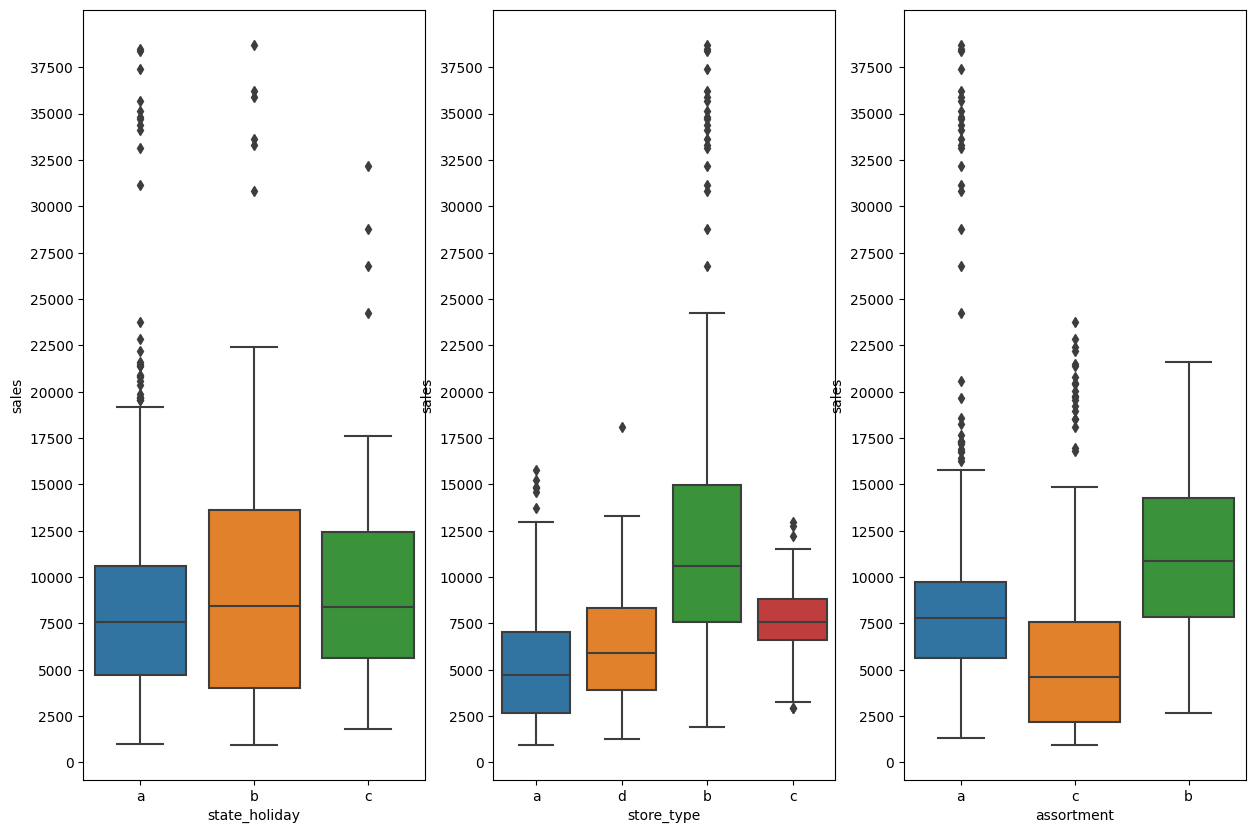

In [16]:
# filtro o df1 para plotar o grafico
aux1 = df1.loc[ (df1['state_holiday'] != '0') & (df1['sales'] > 0), : ]

# defino o tamanho dos graficos
plt.figure( figsize = ( 15,10 ) )

# plotando o grafico boxplot para entender a dispersao das variaveis categoricas em relacao as vendas 
plt.subplot( 1 ,3 , 1 )
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1 )
plt.yticks(range(0 , aux1['sales'].max(), 2500))

plt.subplot( 1, 3 , 2 )
sns.boxplot( x = 'store_type', y = 'sales', data = aux1 )
plt.yticks(range(0 , aux1['sales'].max(), 2500))

plt.subplot( 1, 3 , 3 )
sns.boxplot( x = 'assortment', y = 'sales', data = aux1 )
plt.yticks(range(0 , aux1['sales'].max(), 2500));

# 2.0. PASSO 2 - FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

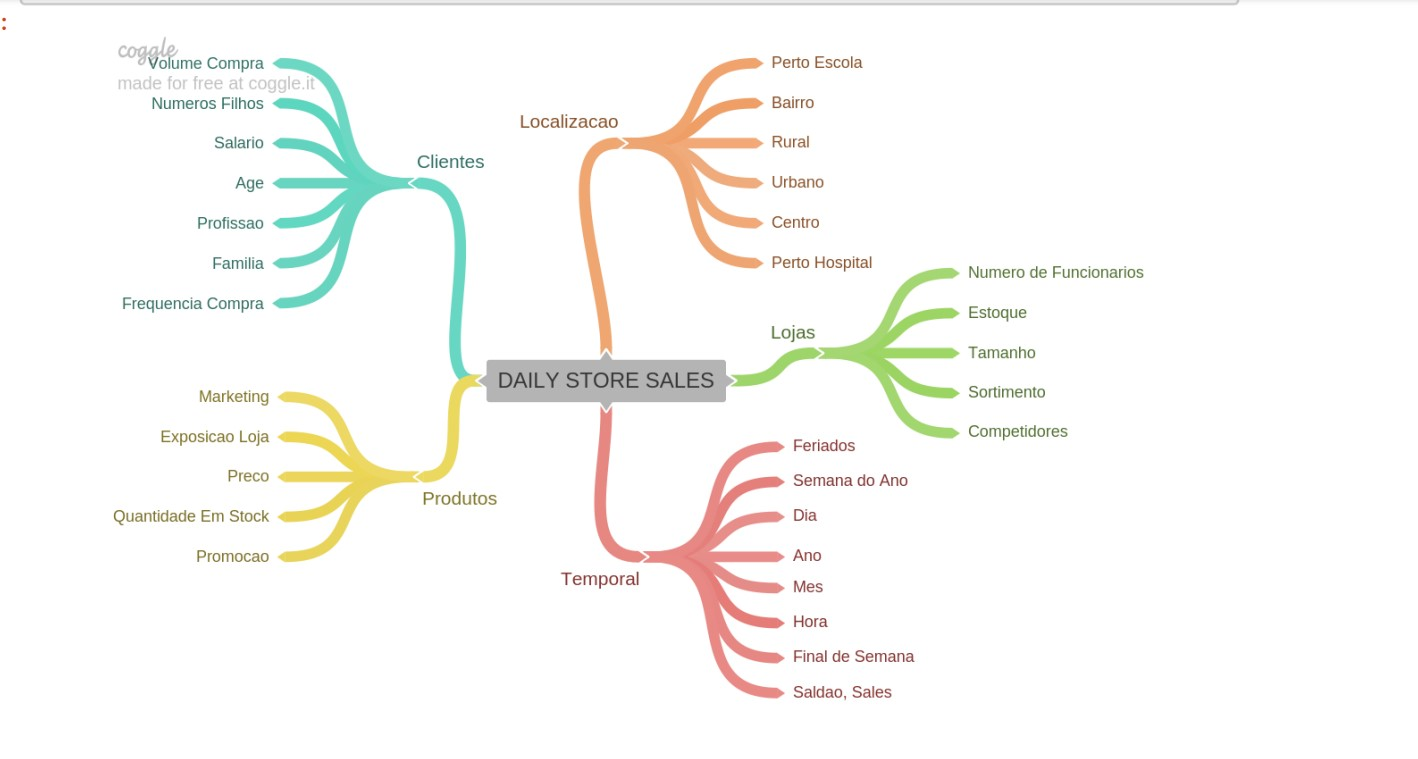

In [18]:
Image( r'img/img_hypothesis.jpg' )

## 2.1.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

## 2.1.2. Hipóteses Produto

**1**. Lojas que investem mais em Marketing deveriam vender mais.

**2**. Lojas com maior exposição de produto deveriam vender mais.

**3**. Lojas com produtos com preço menor deveriam vender mais.

**5**. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6**. Lojas com promoções ativas por mais tempo deveriam vender mais.

**7**. Lojas com mais dias de promoção deveriam vender mais.

**8**. Lojas com mais promoções consecutivas deveriam vender mais.

## 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.**  deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. - Feauture Engineering

In [19]:
# features temporais

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#=======================================================================================================================#

# competition since - nova coluna que leva em consideração o ano e o mes da competição
df2['competition_since'] = df2.apply( lambda x: datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ) , axis= 1) 

# competition time month - Tempo de competição em meses
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

# promo since - Desde quando a promoção ativa
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x : datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta(  days = 7 ) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days ).astype( 'int64' )



# assortment
df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [20]:
df3 = df2.copy()

In [21]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. - Filtragem de Linhas



In [22]:
# filtros as variáveis que não terei no momento da predição
df3 = df3.loc[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ), : ]

## 3.2. - Filtragem de Colunas

In [23]:
# filtragem de colunas - as colunas que não vou passar no momento da predição. Neste caso customers
cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map' ]

df3 = df3.drop( cols_drop, axis = 1  )

# 4.0. - PASSO 04 - ANALISE EXPLORATORIA DE DADOS 

In [24]:
df4 = df3.copy()

## 4.1. - Analise Univariada

### 4.1.1 - Response Variable

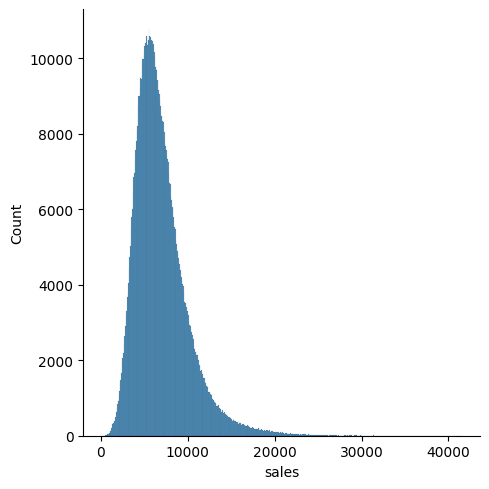

In [25]:
sns.displot( df4['sales'] ) 

### 4.1.2 - Numerical Variable

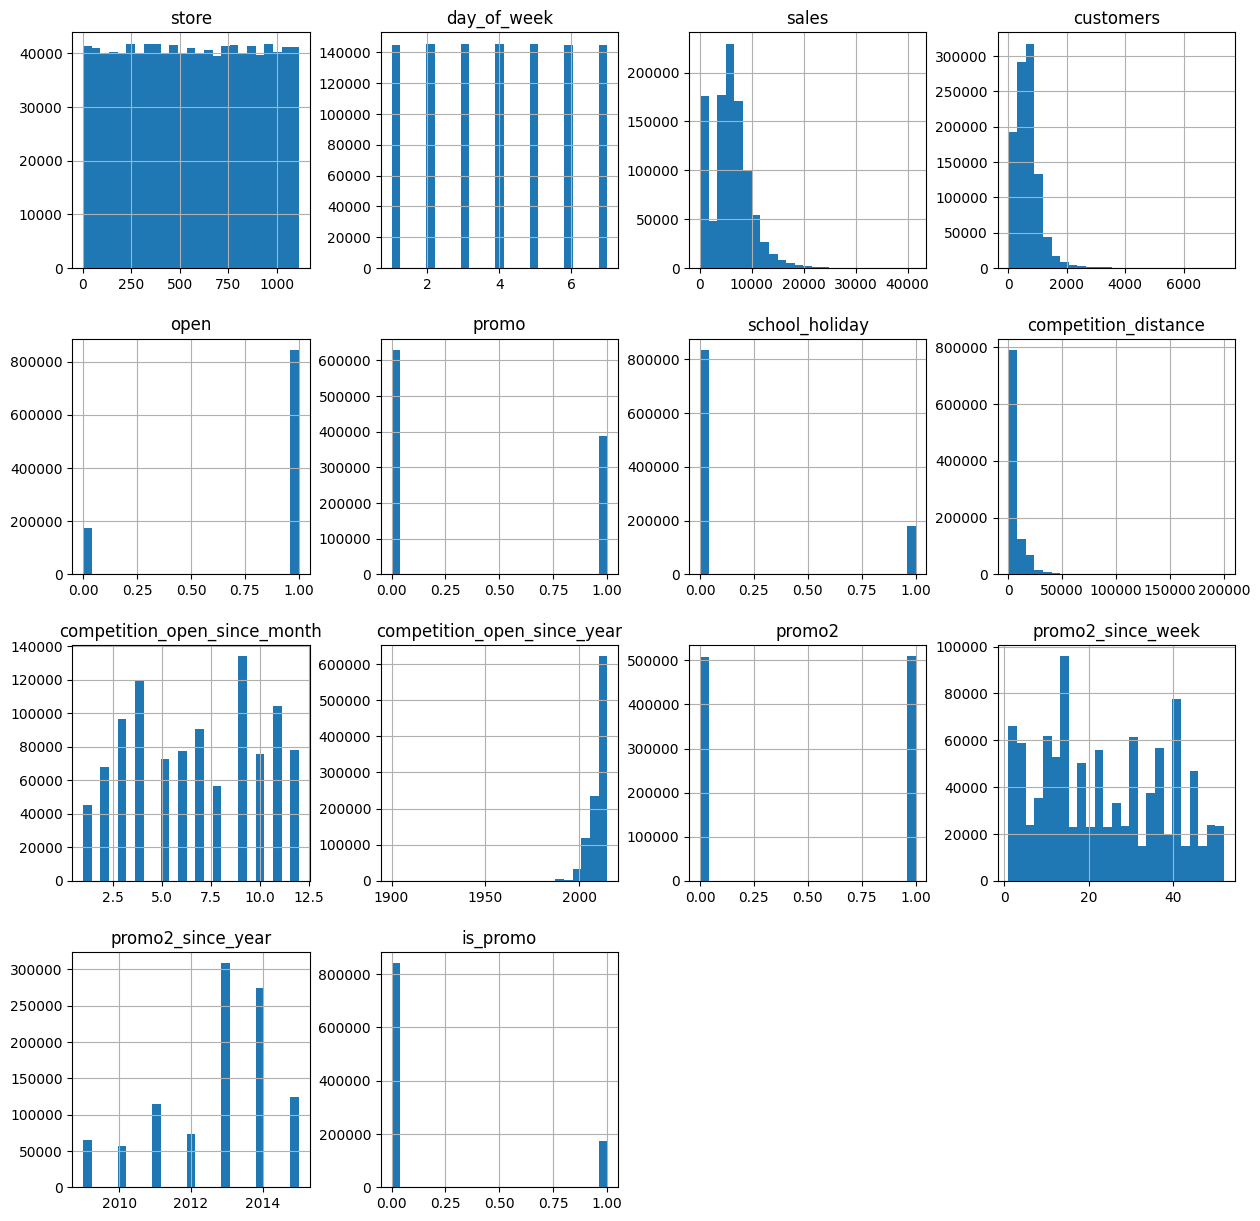

In [26]:
num_attributes.hist( bins = 25, figsize=( 15,15 ) );

### 4.1.3 - Categorical Variable

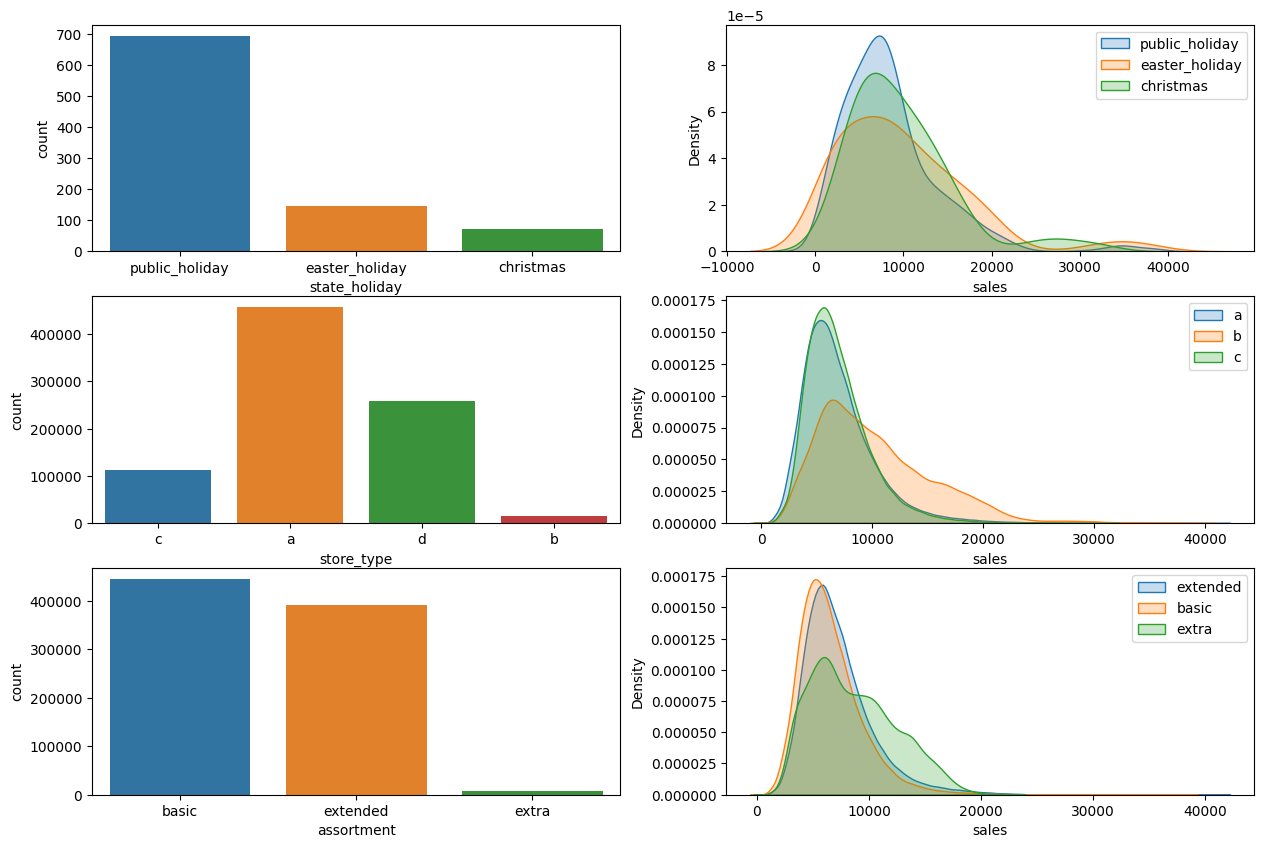

In [27]:
plt.figure( figsize = ( 15,10 ) )
plt.subplot( 3, 2 , 1 )
# filtro o df removendo o regular_day
a = df4.loc[ df4['state_holiday'] != 'regular_day', : ]

# state_holiday
sns.countplot( a, x = 'state_holiday') 

# distribuição do state_holiday
plt.subplot( 3 , 2 , 2 )
sns.kdeplot( df4.loc[ df4['state_holiday'] == 'public_holiday', 'sales' ], label = 'public_holiday', fill = True )
sns.kdeplot( df4.loc[ df4['state_holiday'] == 'easter_holiday', 'sales' ], label = 'easter_holiday', fill = True )
sns.kdeplot( df4.loc[ df4['state_holiday'] == 'christmas', 'sales' ], label = 'christmas', fill = True )
plt.legend()

# store_type
plt.subplot( 3, 2 , 3 )
sns.countplot( data = df4, x = 'store_type'  )

plt.subplot( 3, 2 , 4 )
sns.kdeplot( df4.loc[ df4['store_type'] == 'a', 'sales' ], label = 'a', fill = True )
sns.kdeplot( df4.loc[ df4['store_type'] == 'b', 'sales' ], label = 'b', fill = True )
sns.kdeplot( df4.loc[ df4['store_type'] == 'c', 'sales' ], label = 'c', fill = True )
plt.legend()

# assortment
plt.subplot( 3, 2 , 5 )
sns.countplot( data = df4 , x = 'assortment' )

plt.subplot( 3, 2 , 6 )
sns.kdeplot( df4.loc[ df4['assortment'] == 'extended', 'sales' ], label = 'extended', fill = True )
sns.kdeplot( df4.loc[ df4['assortment'] == 'basic', 'sales' ], label = 'basic', fill = True )
sns.kdeplot( df4.loc[ df4['assortment'] == 'extra', 'sales' ], label = 'extra', fill = True )
plt.legend()

## 4.2. - Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
 - **Falsa** Lojas com maior sortimentos vendem menos.


<Axes: xlabel='year_week'>

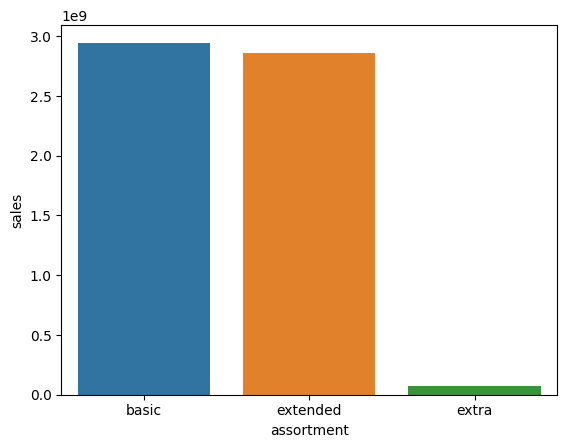

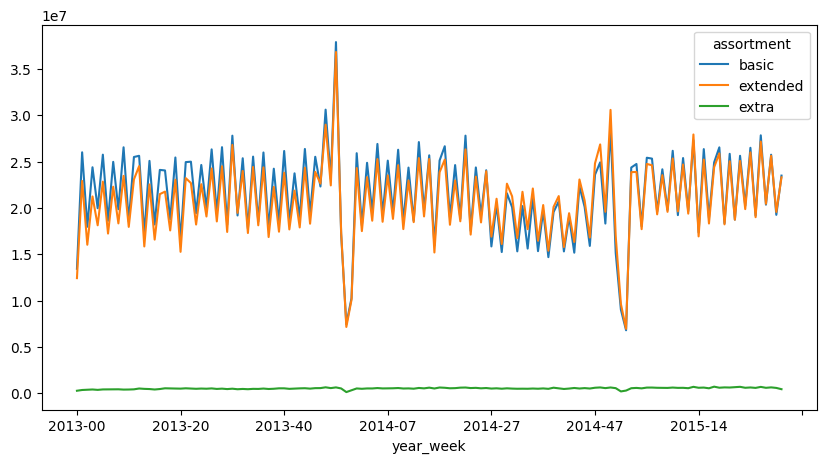

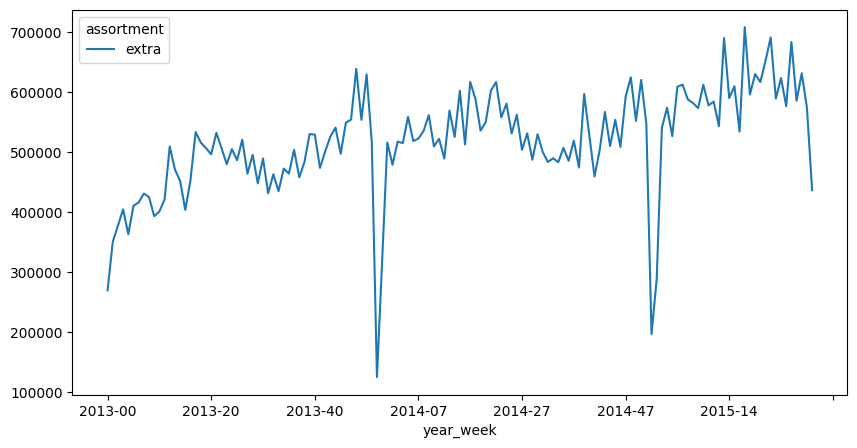

In [28]:
aux1 = df4[['sales','assortment']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x = 'assortment', y = 'sales', data = aux1 )


# analisar ao longo do tempo com as semanas do ano
aux2 = df4[['sales','assortment','year_week']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot(figsize=(10,5))

# analisando somente as vendas extra ao longo das semanas do ano
aux3 = aux2.loc[ aux2['assortment'] == 'extra', : ]
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot(figsize=(10,5))


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
- **Falso** Lojas com competidores mais próximos vendem mais.

C:\Users\oscar\AppData\Local\Temp\ipykernel_8900\1768818172.py:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )


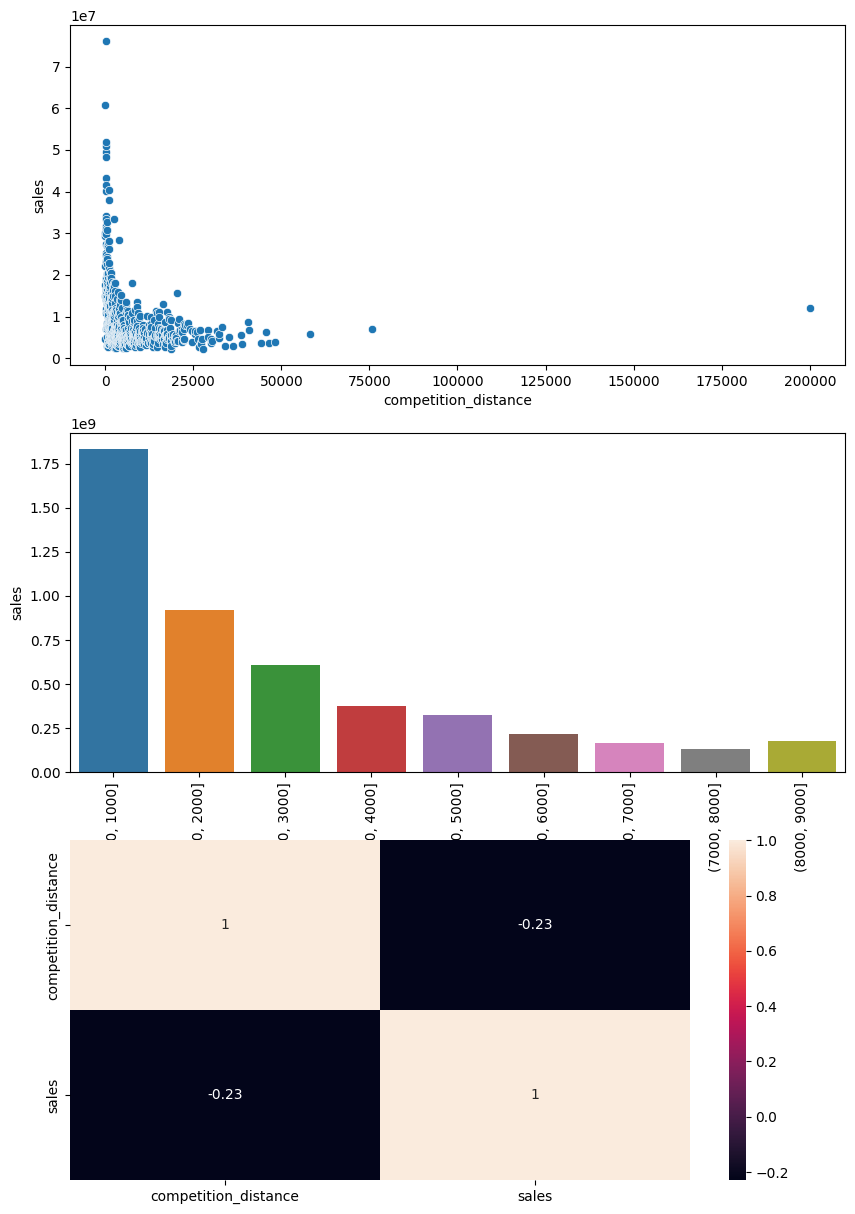

In [29]:
plt.figure( figsize = (10,15) )
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance' ).sum().reset_index()# pego as colunas que preciso

# scatterplot
plt.subplot( 3,1,1 )
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1 )

bins = np.arange( 0, 10000, 1000 )# crio os bins para plotar o barplot

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )# crio uma nova coluna com os bins

aux2 = aux1[['competition_distance_binned','sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

# barplot
plt.subplot( 3,1,2 )
# defino e ploto o grafico de barras
sns.barplot( x = 'competition_distance_binned', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 )

# heatmap
plt.subplot( 3,1,3)
x = sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )


### **H3**. Lojas com competidores à mais tempo deveriam vendem mais.

- **Falsa** Lojas com competidores há mais tempo vedem menos.

<Axes: >

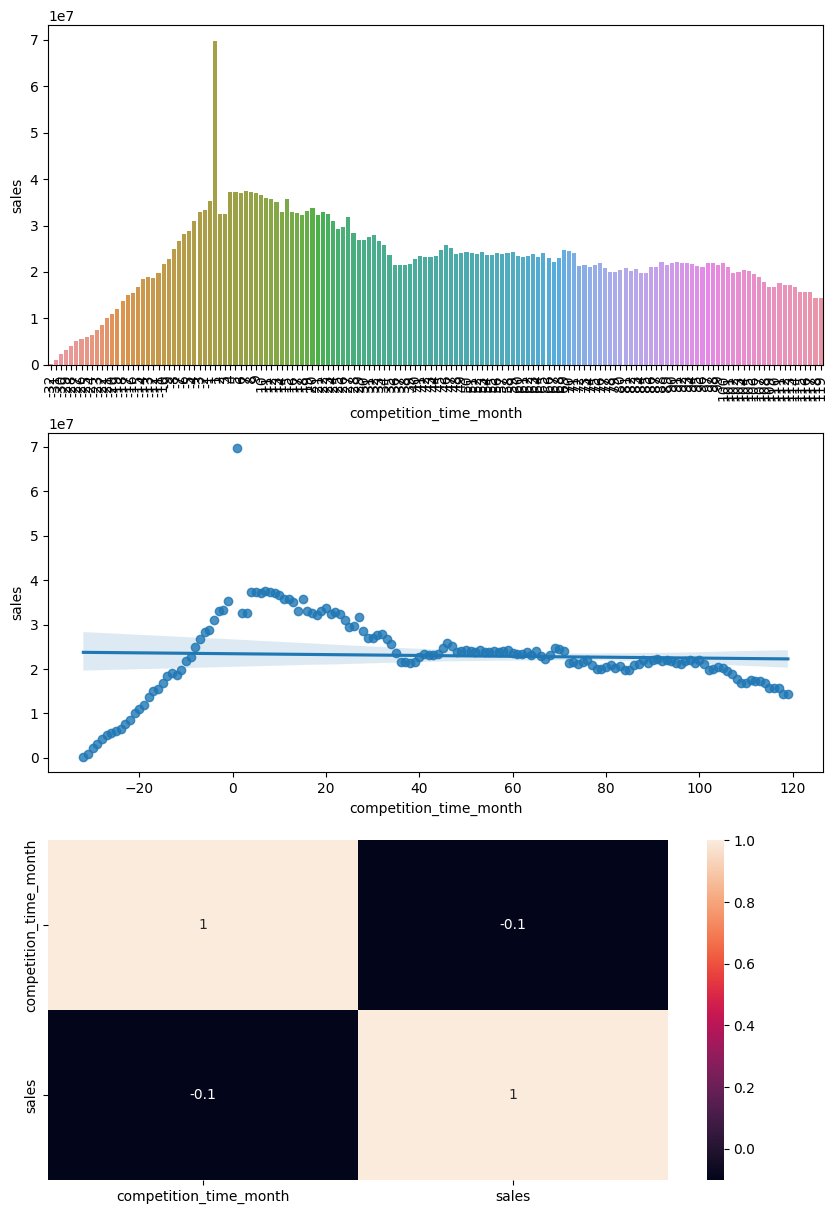

In [30]:
plt.figure( figsize= (10,15) )

# barplot
plt.subplot( 3,1,1 )
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1.loc[(aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) , :]
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 );

# regplot
plt.subplot( 3,1,2 )
sns.regplot( x = 'competition_time_month', y = 'sales', data = aux2 )

# heatmap
plt.subplot( 3,1,3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
 - **Falsa** Porque lojas com promoções ativas por mais tempo, vendem menos depois de um certo período de promoção.

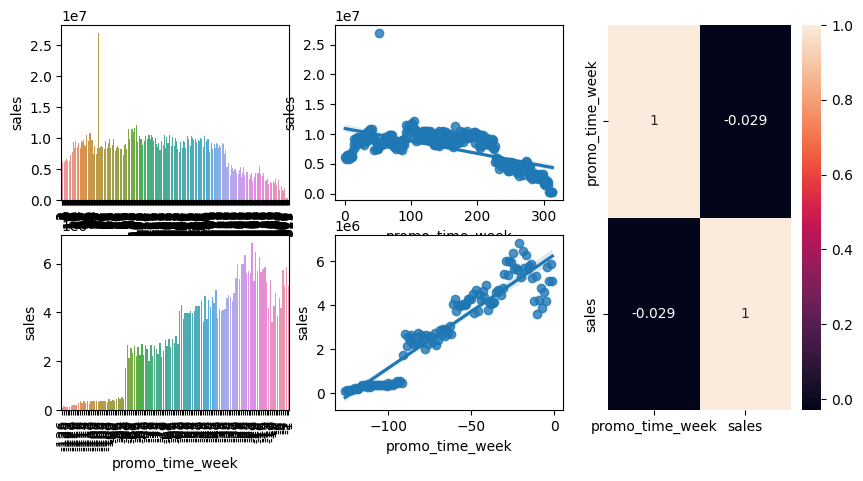

In [31]:
plt.figure(figsize = (10,5)) # defino tamanho do grafico
aux1 = df4[['promo_time_week','sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2,3 )

plt.subplot( grid[ 0 , 0 ] )
aux2 = aux1.loc[ aux1['promo_time_week'] > 0 , : ] # promoção extendida
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2 );
plt.xticks( rotation = 90 );

plt.subplot( grid[0,1] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2 );

plt.subplot( grid[ 1,0 ] )
aux3 = aux1.loc[ aux1['promo_time_week'] < 0  ] # promoção regular
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks( rotation = 90 );

plt.subplot( grid[ 1,1 ] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( 'pearson' ), annot = True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s> Ficará para um próximo ciclo do crisp

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

 - **Falsa** Lojas com mais promoções consecutivas vendem menos.

In [32]:
df4[['promo','promo2','sales']].groupby( ['promo','promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


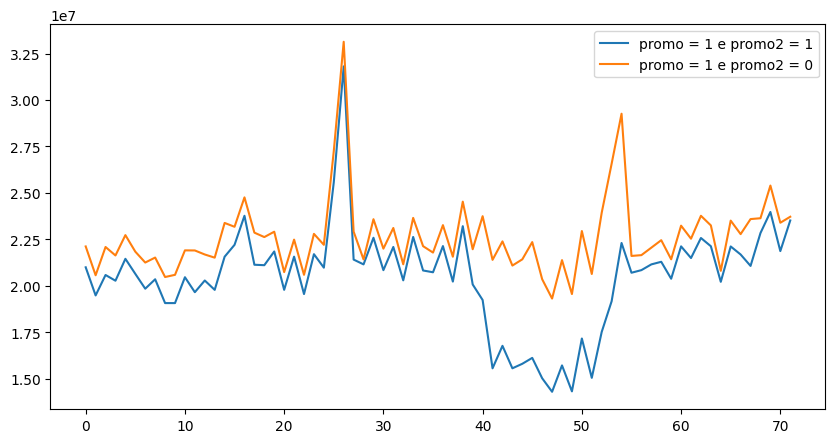

In [33]:
# lojas que participaram na promo tradicional e extendido
aux1 = df4.loc[ (df4['promo'] == 1) & ( df4['promo2'] == 1 ), ['year_week','sales'] ].groupby('year_week').sum().reset_index()
ax = aux1.plot();

# lojas que tiveram somente o periodo tradicional extendido
aux2 =df4.loc[ (df4['promo'] == 1) & (df4['promo2'] == 0), ['year_week','sales'] ].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax = ax, figsize = (10,5) );

ax.legend( labels = [ 'promo = 1 e promo2 = 1', 'promo = 1 e promo2 = 0' ] );

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

 - **Falsa** Lojas vendem menos durante o feriado de natal


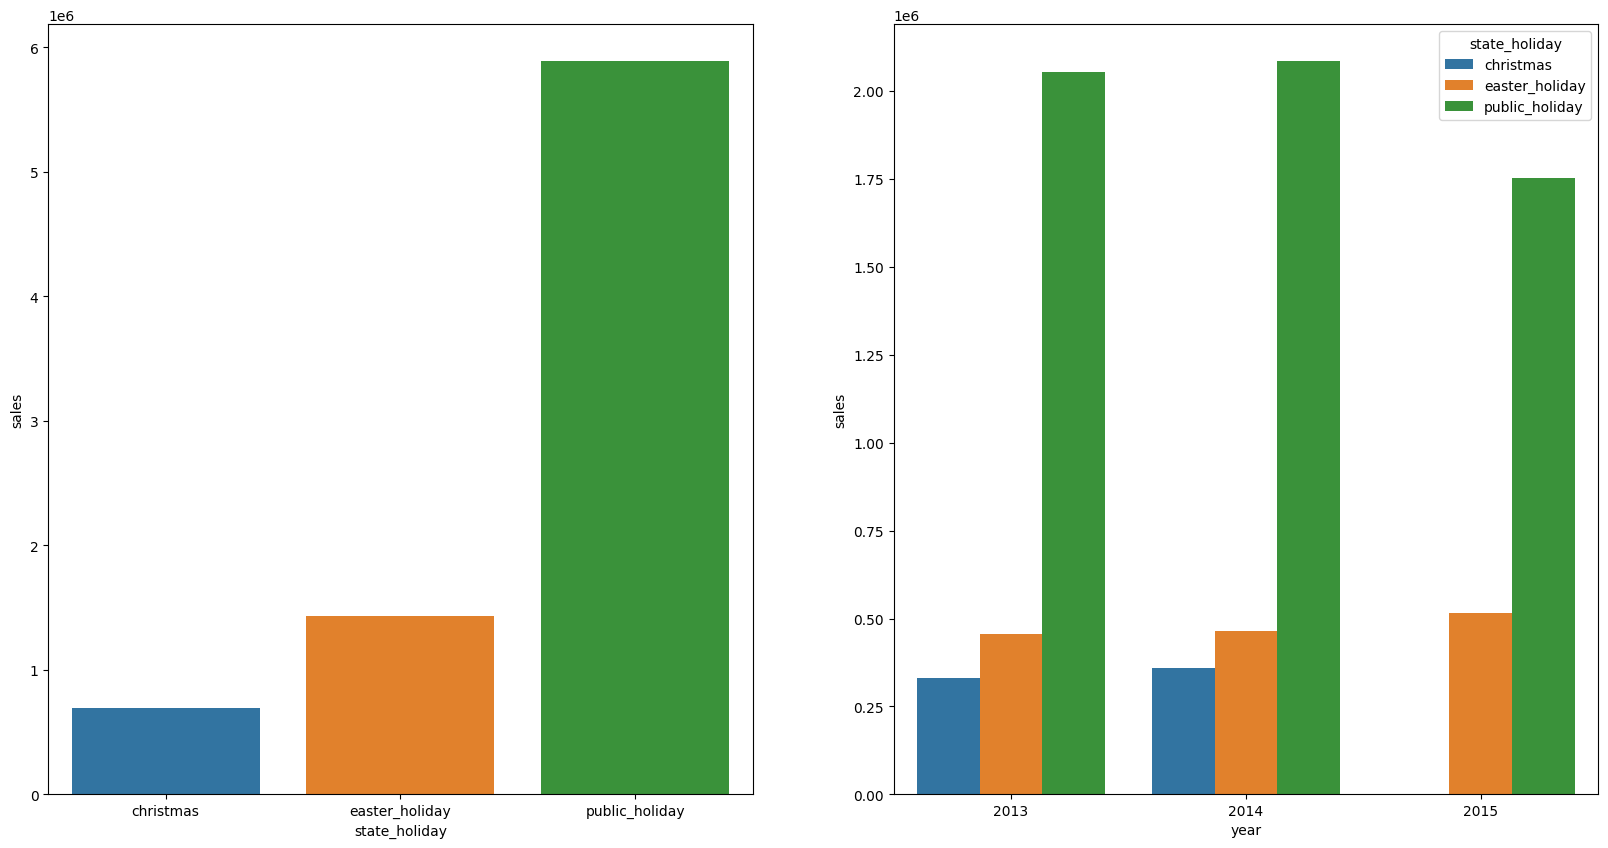

In [34]:
plt.figure( figsize= (20,10) )
plt.subplot( 1,2,1 )
aux1 = df4[['state_holiday','sales']].groupby( 'state_holiday' ).sum().reset_index()
aux1 = aux1.loc[ aux1['state_holiday'] != 'regular_day', : ]
sns.barplot( x = 'state_holiday', y = 'sales', data = aux1 );

# verificar se o feriado de natal já vendeu mais em algum ano
plt.subplot( 1,2,2, )
aux2 = df4[['year','state_holiday','sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
aux2 = aux2.loc[ aux2['state_holiday'] != 'regular_day', : ]
sns.barplot( x = 'year', y = 'sales', data = aux2 , hue = 'state_holiday' );

### **H8.**  deveriam vender mais ao longo dos anos.
 - **Falsa** Lojas vendem menos ao longo dos anos.

<Axes: >

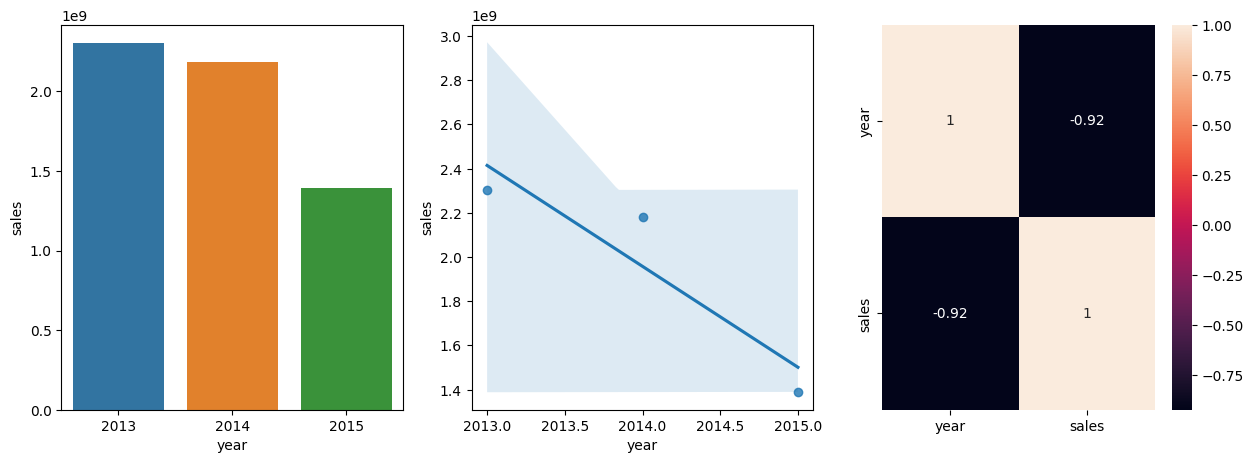

In [35]:
plt.figure( figsize= (15,5) )
plt.subplot( 1,3,1 )
aux1 = df4[['year','sales']].groupby( 'year' ).sum().reset_index()
sns.barplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x = 'year', y = 'sales', data = aux1 )

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method = 'pearson'), annot = True ) 

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
 - **Falsa** Lojas vendem menos no segundo semestre

<Axes: >

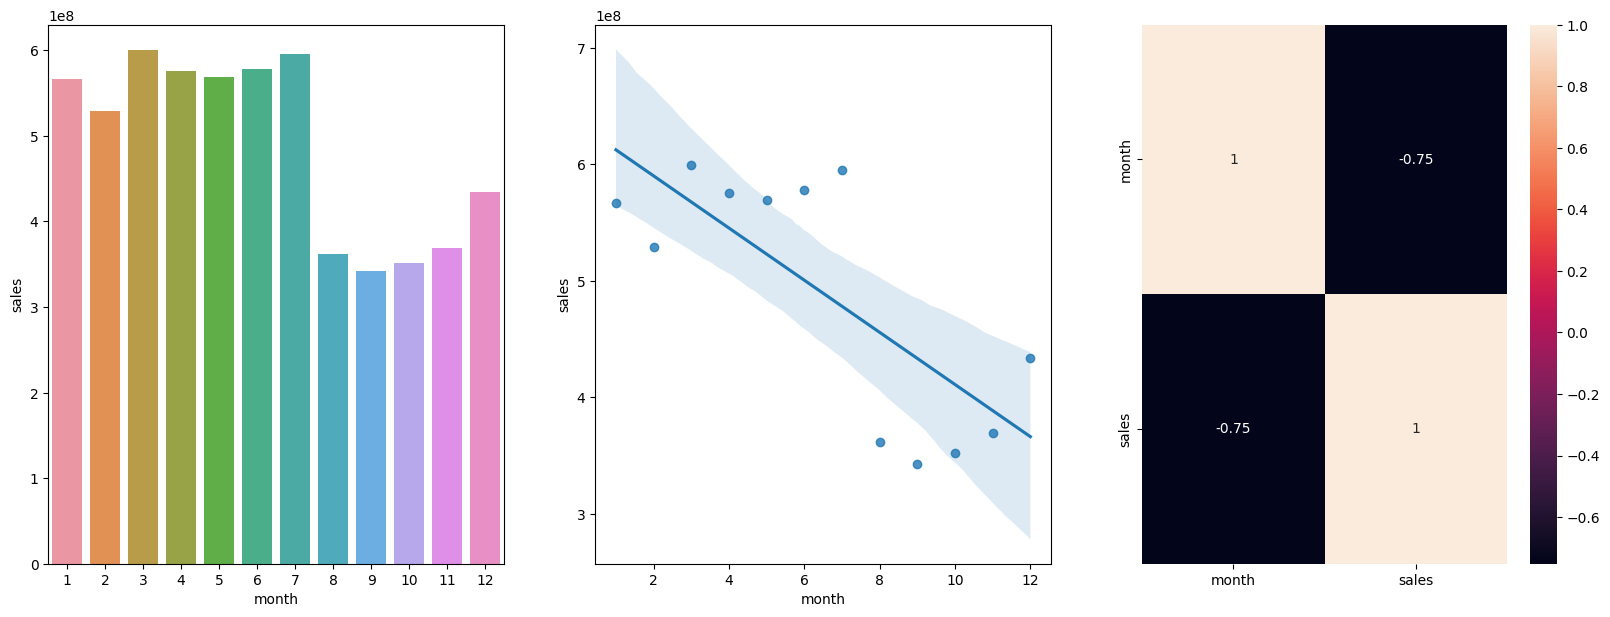

In [36]:
plt.figure( figsize = (20,7) )
aux1 = df4[['month','sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1,3,1 )
sns.barplot( x = 'month', y = 'sales', data = aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x = 'month', y = 'sales', data = aux1 )

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
 - **Verdadeira** Lojas vendem mais depois do dia 10 de cada mês.

<Axes: xlabel='before_after', ylabel='sales'>

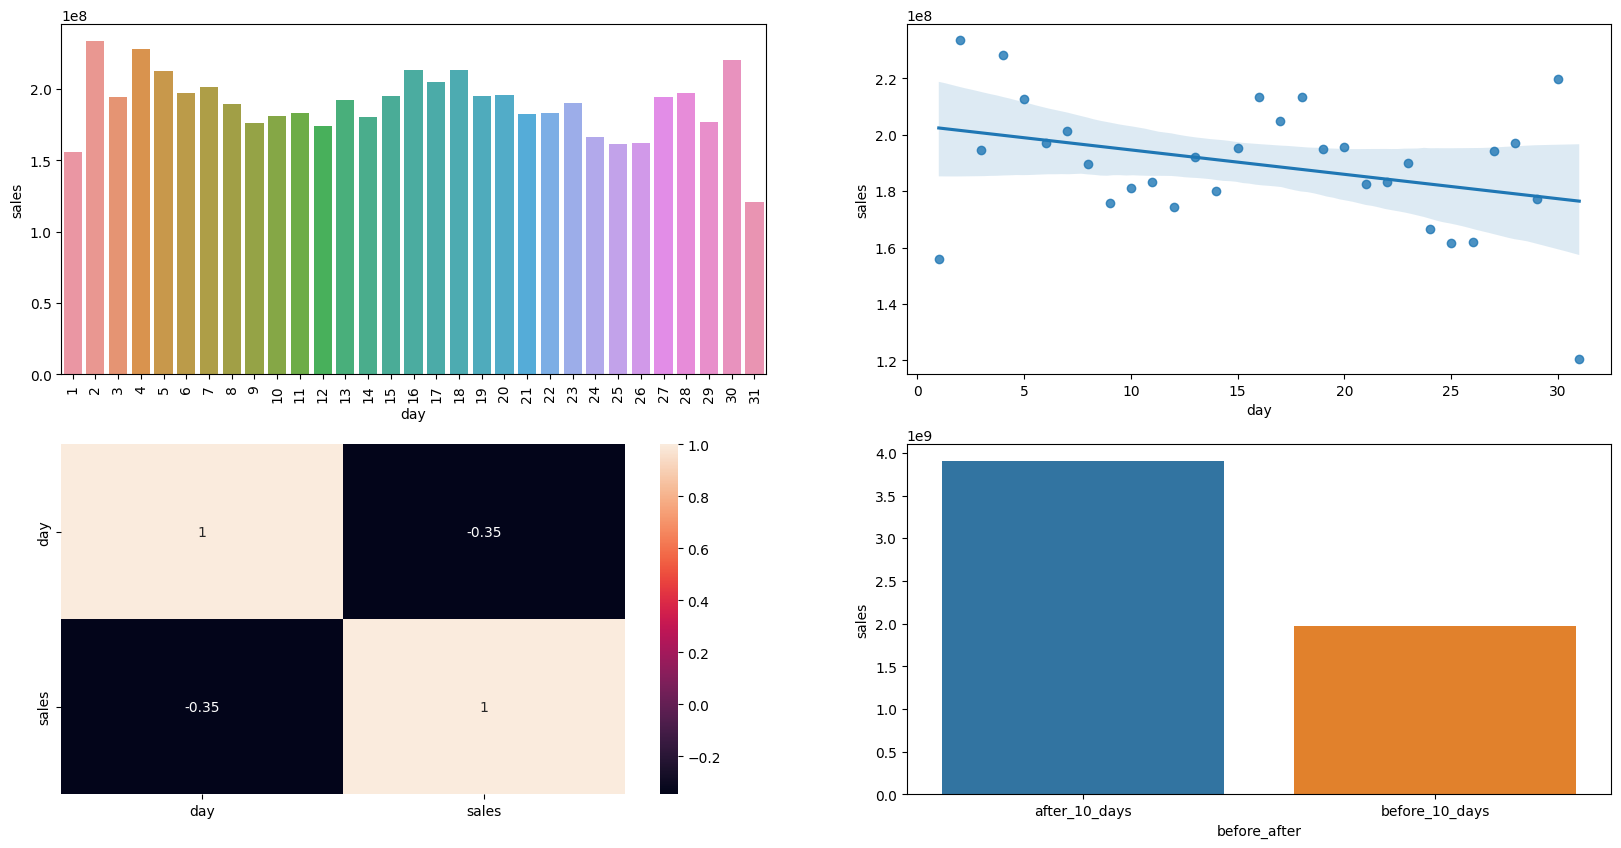

In [37]:
plt.figure( figsize = (20,10) )
plt.subplot( 2,2,1 )
aux1 = df4[['day','sales']].groupby( 'day' ).sum().reset_index()
sns.barplot( x = 'day', y = 'sales', data = aux1 );
plt.xticks( rotation = 90 )

plt.subplot( 2,2,2 )
sns.regplot( x= 'day', y = 'sales', data = aux1 )

plt.subplot( 2,2,3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

plt.subplot( 2,2,4 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after','sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data = aux2 )

### **H11.** Lojas deveriam vender menos aos finais de semana.
 - **Verdadeiro** Lojas vendem menos nos finais de semana

<Axes: >

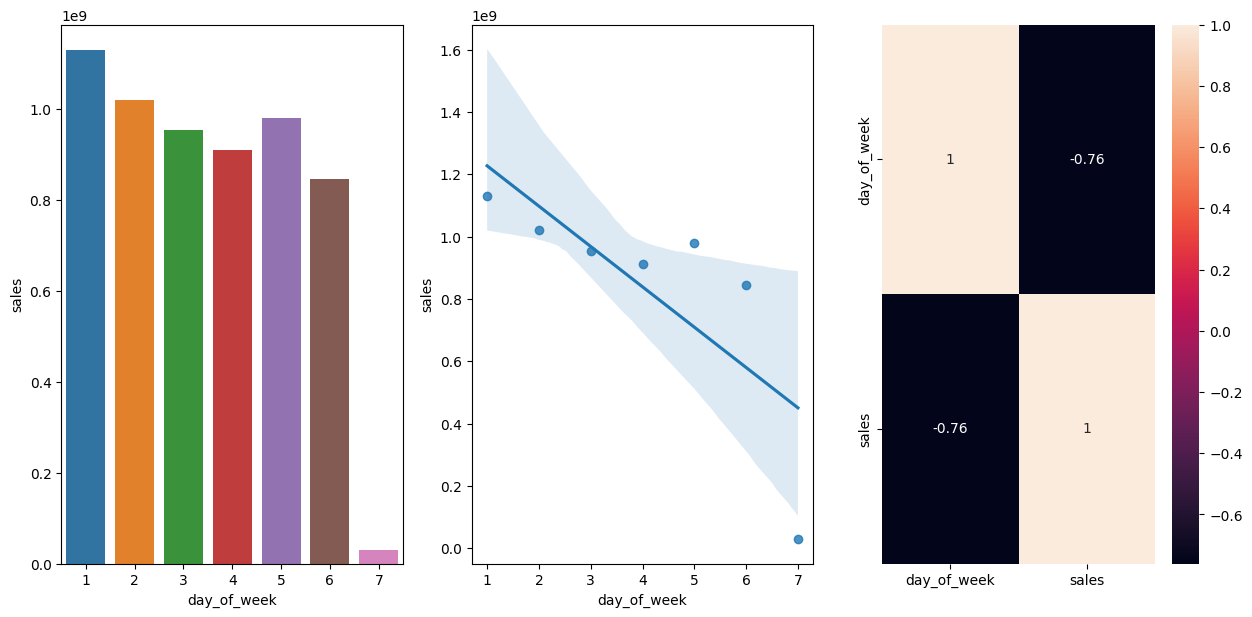

In [38]:
plt.figure( figsize=(15,7) )
plt.subplot( 1,3,1 )
aux1 = df4[['day_of_week','sales']].groupby( 'day_of_week' ).sum().reset_index()
sns.barplot( x ='day_of_week', y = 'sales', data = aux1 )

plt.subplot( 1,3,2 )
sns.regplot( x = 'day_of_week', y = 'sales', data = aux1 )

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
 - **Verdadeiro** Lojas vendem menos durante os feriados escolares.

<Axes: xlabel='month', ylabel='sales'>

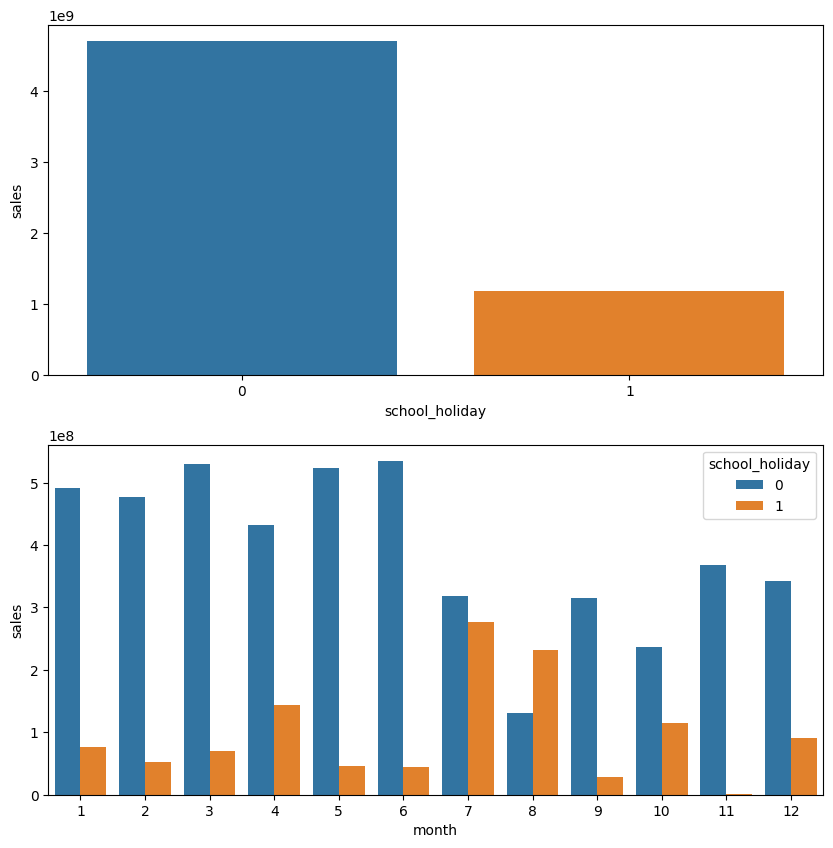

In [39]:
plt.figure( figsize = (10,10) )
plt.subplot( 2,1,1 )
aux1 = df4[['school_holiday','sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1  )

plt.subplot( 2,1,2 )
aux2 = df4[['month','school_holiday','sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', data = aux2, hue = 'school_holiday' )


### 4.2.1 Resumo das Hipoteses

In [40]:
tab = [['Hipotese', 'Conclusão', 'Relevância para o modelo'],
       ['H1','Falsa','Baixa'],
       ['H2','Falsa','Média'],
       ['H3','Falsa','Média'],
       ['H4','Falsa','Baixa'],
       ['H5','-','-'],
       ['H6','Falsa','Baixa'],
       ['H7','Falsa','Média'],
       ['H8','Falsa','Alta'],
       ['H9','Falsa','Alta'],
       ['H10','Verdadeira','Alta'],
       ['H11','Verdadeira','Alta'],
       ['H12','Verdadeira','Baixa']
       
    
]
print( tabulate( tab , headers = 'firstrow' ))

Hipotese    Conclusão    Relevância para o modelo
----------  -----------  --------------------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Média
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3. - Analise Multivariada

### 4.3.1 - Numerical Attributes

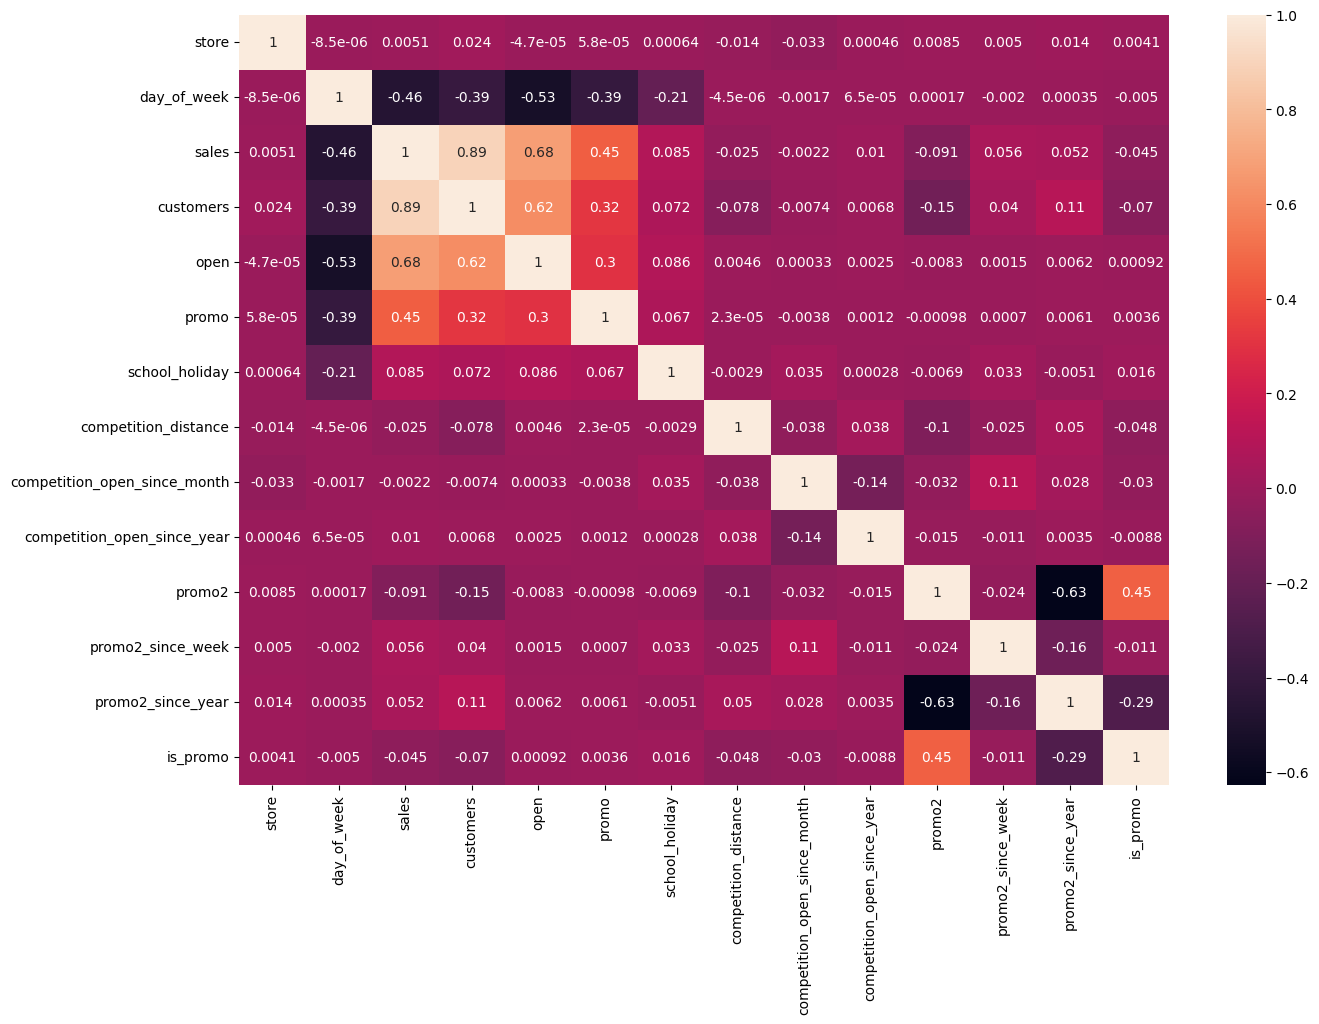

In [41]:
plt.figure( figsize = (15,10) )
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

### 4.3.2 - Categorical Attributes

In [42]:
a = df4.select_dtypes( include = ['object'] ) # pego o df mais atualizado

In [43]:
# aplico a função cramer v nas variáveis categoricas
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday' : [a1,a2,a3],
               'store_type' : [a4,a5,a6],
               'assortment' : [a7,a8,a9]
              
              } )

d = d.set_index( d.columns )


<Axes: >

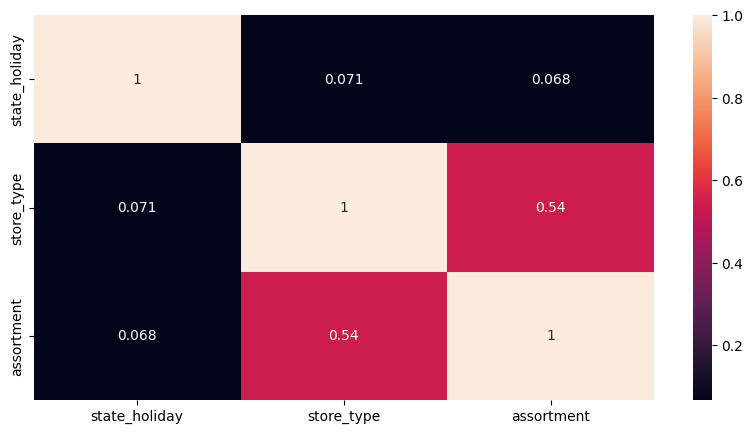

In [44]:
# vejo a correlação entre as variáveis
plt.figure( figsize = (10,5) )
sns.heatmap( d, annot = True )

# 5.0. - PASSO 05 - DATA PREPARATION 

In [45]:
df5 = df4.copy()

## 5.1. - Normalização

### Funciona bem para variáveis com distribuição normal. No meu caso não tenho variáveis com distr.normal

## 5.2. - Rescaling

In [46]:
# usado para variáveis que não tem distribuição normal
a = df5.select_dtypes( include = ['float64','int64'] )

In [48]:
rs = RobustScaler() # usado para variáveis que tem outliers
mms = MinMaxScaler() # usado para variáveis que não tem outliers
# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3. - Transformação

### 5.3.1 - Encoding

In [49]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies( df5 , prefix = 'state_holiday', columns = ['state_holiday'] )

# store_type - Labelencoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assorment - ordinal encoding
assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 - Response Variable Transformation

In [50]:
df5['sales'] = np.log1p( df5['sales'] )

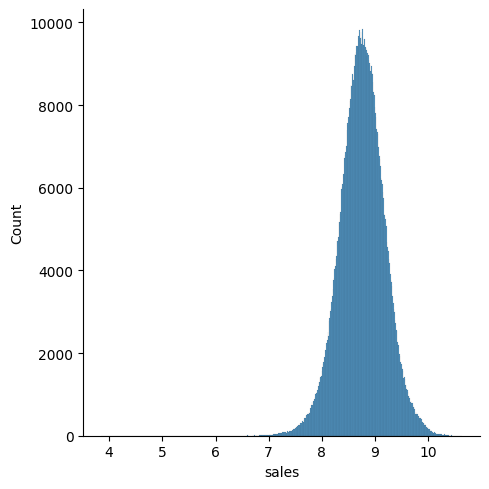

In [51]:
sns.displot( df5['sales'] )

### 5.3.2 Nature Transformation

In [52]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi / 7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi / 7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x : np.sin( x * ( 2. * np.pi / 30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x : np.cos( x * (2. * np.pi / 30) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 )  ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi / 52 ) ) )

# 6.0. - PASSO 06 - FEATURE SELECTION

In [53]:
df6 = df5.copy()

## 6.1. - Split dataset into training and Test dataset

In [54]:
# crio uma lista com as colunas das quais derivei as variaveis ( senão ficarão duplicadas )
cols_drop = ['week_of_year','day','month','day_of_week','promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis = 1 )

In [55]:
# calculo a data minima por loja
df6[['date','store']].groupby( 'store' ).min().reset_index()['date'][2] # vejo a data minima

# vejo a data maxima e subtraio 6 semanas
df6[['date','store']].groupby( 'store' ).max().reset_index()['date'][2] - timedelta( days = 6*7) 

# training dataset
X_train = df6.loc[ df6['date'] < '2015-06-19', : ] 
y_train = X_train['sales']

# test dataset
X_test = df6.loc[ df6['date'] >= '2015-06-19', : ] # ultimas seis semanas do dataset
y_test = X_test['sales']

print( 'Training Min Date {} '.format( X_train['date'].min() ) )
print( 'Training Max Date {}'.format( X_train['date'].max() ) )

print( '='*100 )

print( 'Test Min Date {}'.format( X_test['date'].min() ) )
print( 'Test Max Date {}'.format( X_test['date'].max() ) )


Training Min Date 2013-01-01 00:00:00 
Training Max Date 2015-06-18 00:00:00
Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.2. - Boruta as Feature Selector

In [56]:
# # training and test dataset for boruta
# X_train_n = X_train.drop( ['sales' , 'date'] , axis= 1 ).values
# y_train_n = y_train.values.ravel()

# # instancia do Rf
# rf = RandomForestRegressor( n_jobs = -1 )

# # aplico o boruta
# boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train_n, y_train_n )

# # pega as colunas e coloca na variavel
# cols_selected = boruta.support_.tolist()

# # df boruta
# df_boruta = df6.loc[ : , cols_selected]

In [57]:
# # lista com as colunas ( bool)
# cols_selected = boruta.support_.tolist()

# # cols selected boruta
# X_train_fs = X_train.drop( ['sales','date'], axis = 1 )
# cols_selected_boruta = X_train_fs.loc[ : , cols_selected ]

# # cols not selected boruta
# cols_not_selected = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta.columns ) )

## 6.3. - Manual Feature Selection

In [58]:
# colunas selecionadas
cols_selected_boruta = ['store', 
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']

# columns to add
feat_to_add = ['date','sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. - PASSO 07 - MACHINE LEARNING MODELLING

In [59]:
# training data
x_train = X_train[ cols_selected_boruta ]

# test data
x_test = X_test[ cols_selected_boruta ]

In [60]:
# definindo o x_training - inclui as colunas de 'date' e 'sales' usados para o cross validation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. - Average Model 

In [61]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction 
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales': 'prediction'} )
aux1 = pd.merge( aux1, aux2 , how = 'left', on = 'store' )
y_hat_baseline = aux1['prediction']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ) , np.expm1( y_hat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. - Linear Regression Model

In [62]:
# model
lr = LinearRegression().fit( x_train , y_train )

# prediction
y_hat_lr = lr.predict( x_test )

# performance 
lr_result = ml_error( 'Linear Regression Model', np.expm1(  y_test  ) , np.expm1( y_hat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,1867.089774,0.292694,2671.049215


## 7.2.1 - Linear Regression Model - Cross Validation

In [63]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression Cv', lr , verbose = False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Cv,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. - Linear Regression Regularized Model - Lasso

In [64]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train , y_train )

# prediction
y_hat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Lasso', np.expm1( y_test ) , np.expm1( y_hat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.704881,0.289106,2744.451737


## 7.3.1 - Linear Regression Regularized Model - Lasso - CV

In [65]:
lasso_cv = cross_validation( x_training, 5, 'Lasso Cv', lrr, verbose = False )
lasso_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso Cv,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. - Random Forest Regressor

In [66]:
# model
rf = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42  ).fit( x_train , y_train )

# prediction
y_hat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ) , np.expm1( y_hat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.455795,0.099667,1007.9169


## 7.4.1 - Random Forest Regressor - CV 

In [72]:
rf_cv = cross_validation( x_training, 5, 'Random Forest Regressor Cv', rf, verbose = True )
rf_cv


 kfold number5

 kfold number4

 kfold number3

 kfold number2

 kfold number1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor Cv,838.23 +/- 218.1,0.12 +/- 0.02,1257.07 +/- 318.2


## 7.5. - XGBoost Regressor 

In [73]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit( x_train , y_train )

# prediction
y_hat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ) , np.expm1( y_hat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.52581,0.949454,7330.787662


## 7.5.1 - XGBoost Regressor - CV 

In [74]:
xgb_cv = cross_validation( x_training, 5, 'XGBoost Regressor Cv', model_xgb , verbose = False )
xgb_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor Cv,7049.18 +/- 588.64,0.95 +/- 0.0,7715.21 +/- 689.51


## 7.6. - Compare Model's Performance

## 7.6.1 - Single Performance

In [75]:
modelling_result = pd.concat( [baseline_result,lr_result,lrr_result,rf_result,xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.455795,0.099667,1007.916900
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression Model,1867.089774,0.292694,2671.049215
0,Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.525810,0.949454,7330.787662


## 7.6.2 - Real Performance

In [80]:
modelling_result_cv = pd.concat( [lr_result_cv,lasso_cv,rf_cv, xgb_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )  

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor Cv,838.23 +/- 218.1,0.12 +/- 0.02,1257.07 +/- 318.2
0,Linear Regression Cv,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso Cv,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor Cv,7049.18 +/- 588.64,0.95 +/- 0.0,7715.21 +/- 689.51


# 8.0. - PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. - Random Search

In [76]:
param = {'n_estimators' : [15,17,25,30,35],
         'eta' : [0.01,0.03],
         'max_depth' : [3,5,9],
         'subsample' : [0.1,0.5,0.7],
         'colsample_mbytree' : [0.3,0.7,0.9],
         'min_child_weight' : [3,8,15]}

MAX_EVAL = 3

In [77]:
final_result = pd.DataFrame( )

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k : random.sample( v,1 )[0] for k,v in param.items()}
    print( hp )
    # model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                 n_estimators = hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytree = hp['colsample_mbytree'],
                                 min_child_weight = hp['min_child_weight'])
    # performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb , verbose=False)
    final_result = pd.concat( [final_result, result] )
    
final_result

{'n_estimators': 15, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_mbytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 35, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_mbytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 17, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_mbytree': 0.3, 'min_child_weight': 8}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7421.31 +/- 128.29,1.0 +/- 0.0,8075.38 +/- 175.38
0,XGBoost Regressor,7057.01 +/- 127.64,0.94 +/- 0.0,7737.02 +/- 176.16
0,XGBoost Regressor,7380.21 +/- 128.32,0.99 +/- 0.0,8037.24 +/- 175.56


## 8.2. - Final Model

In [78]:
param_tuned = {'n_estimators' : 3000 ,
         'eta' : 0.03 ,
         'max_depth' : 5 ,
         'subsample' : 0.7,
         'colsample_mbytree' : 0.7,
         'min_child_weight' : 3 }

In [79]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_mbytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit( x_train, y_train )
# prediction  
y_hat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test) , np.expm1(y_hat_xgb_tuned))

# export model
pickle.dump( model_xgb_tuned, open(r'\users\oscar\Documents\repos\rossmann_sales\trained_model.pkl', 'wb') )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,768.429584,0.115325,1102.709498


In [93]:
# acrescento o erro MPE na tabela final do modelo
xgb_result_tuned['MPE'] = mean_percentage_error(np.expm1 (y_test) ,np.expm1(y_hat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE,MPE
0,XGBoost Regressor,768.429584,0.115325,1102.709498,-0.016659


# 9.0. - PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [175]:
df9 = X_test[ cols_selected_boruta_full ]

In [176]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9.loc[:,'predictions'] = np.expm1( y_hat_xgb_tuned )

C:\Users\oscar\AppData\Local\Temp\ipykernel_8900\1759580448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
C:\Users\oscar\AppData\Local\Temp\ipykernel_8900\1759580448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9.loc[:,'predictions'] = np.expm1( y_hat_xgb_tuned )


## 9.1. - Business Performance

In [182]:
# sum of predictions
df91 = df9[['store','predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions']) ).reset_index().rename( columns = {0:'MAE'} )
df9_aux2 = df9[['store','sales','predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])  ).reset_index().rename( columns = {0:'MAPE'} )

# merge dataframes
df9_aux3 = pd.merge( df9_aux1 , df9_aux2, how = 'inner', on = 'store' )
df92 = pd.merge( df91, df9_aux3, how = 'inner', on = 'store' )

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]
df92

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,167270.421875,166984.515599,167556.328151,285.906276,0.065622
1,2,181102.687500,180670.410684,181534.964316,432.276816,0.087597
2,3,268272.750000,267608.693762,268936.806238,664.056238,0.091174
3,4,343039.125000,342189.635452,343888.614548,849.489548,0.080471
4,5,171468.296875,171105.999175,171830.594575,362.297700,0.080363
...,...,...,...,...,...,...
1110,1111,184803.453125,184118.305822,185488.600428,685.147303,0.153315
1111,1112,340074.687500,339042.855416,341106.519584,1031.832084,0.125032
1112,1113,249962.687500,249384.941446,250540.433554,577.746054,0.089467
1113,1114,783279.937500,781214.182908,785345.692092,2065.754592,0.088179


In [184]:
# lojas dificeis de prever - MAPE alto
df92.sort_values( 'MAPE', ascending = False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106233.296875,102870.282830,109596.310920,3363.014045,0.581204
908,909,217264.781250,209293.137993,225236.424507,7971.643257,0.518163
169,170,207300.765625,205802.470743,208799.060507,1498.294882,0.367992
901,902,202033.734375,200570.876808,203496.591942,1462.857567,0.364407
875,876,190798.968750,186592.694293,195005.243207,4206.274457,0.339242


<Axes: xlabel='store', ylabel='MAPE'>

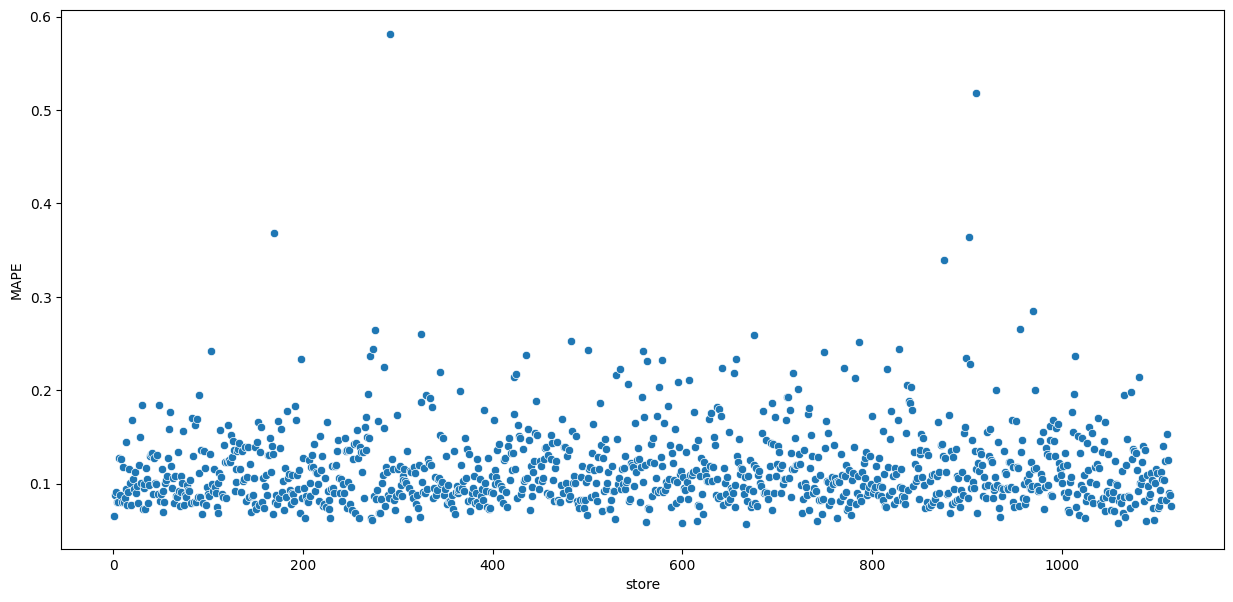

In [189]:
# mostrando de forma visual
plt.figure( figsize = (15,7) )
sns.scatterplot( x = 'store', y = 'MAPE', data = df92 )

## 9.2. - Total Performance

In [197]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply( lambda x: np.sum( x ), axis = 0 ).reset_index().rename( columns = {'index': 'scenario', 0 : 'values'} )
df93['values'] = df93['values'].map( '{:,.2f}'.format )
df93

,scenario,values
0,predictions,"286,102,528.00"
1,worst_scenario,"285,242,454.34"
2,best_scenario,"286,962,658.74"


## 9.3. - Machine Learning Performance

In [198]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\oscar\AppData\Local\Temp\ipykernel_8900\1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\oscar\AppData\Local\Temp\ipykernel_8900\1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


<Axes: xlabel='predictions', ylabel='error'>

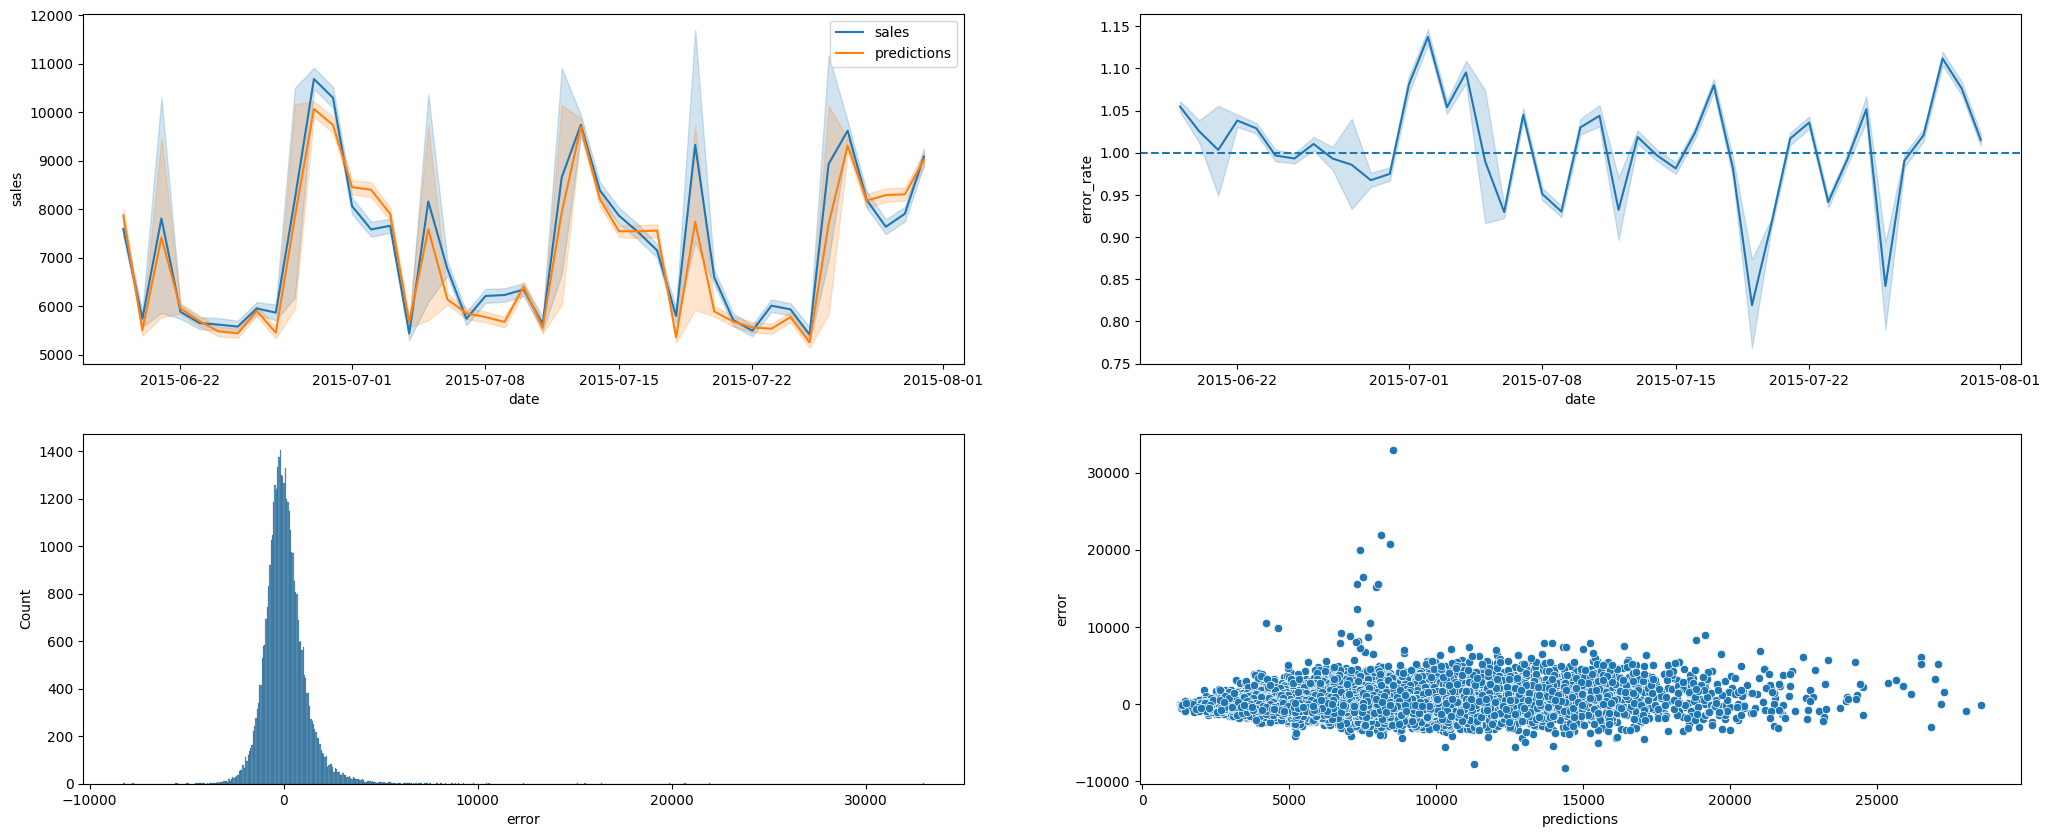

In [214]:
# vendas ao longo do tempo - real x previsão
plt.figure( figsize = (25,10) )
plt.subplot( 2 , 2 , 1 )
sns.lineplot( x = 'date', y = 'sales', data = df9 , label = 'sales')
sns.lineplot( x = 'date', y = 'predictions', data = df9 , label = 'predictions')

plt.subplot( 2 ,2 , 2 )
sns.lineplot( x = 'date', y = 'error_rate', data = df9 )
plt.axhline( 1,linestyle = '--' )

plt.subplot( 2 , 2 ,3 )
sns.histplot( df9['error'] )

plt.subplot( 2 , 2 ,4 )
sns.scatterplot( x = df9['predictions'], y = df9['error'], data = df9 )